# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *R*

**Names:**

* *Raphael Barman*
* *Thierry Bossy*
* *Raphael Strebel*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [97]:
import epidemics_helper
import json
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
import operator as op
import random as rand

In [98]:
def load_graph_from_file():
    with open('../data/nyc_augmented_network.json') as data_file:    
        data = json.load(data_file)
    graph = nx.Graph()
    nb_edges = len(data['links']) - 1
    # Construct the graph edge by edge (there has to be a nicer way)
    for i in range(0, nb_edges):
        graph.add_edge(data['links'][i]['source'], data['links'][i]['target'])
    return graph

In [99]:
# Load the data of nyc network
graph = load_graph_from_file()
print("Number of nodes:", nx.number_of_nodes(graph))
print("Number of edges:", nb_edges)

Number of nodes: 26481
Number of edges: 43436


In [100]:
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(graph, beta=10.0, gamma=0.1)

# Launch epidemic
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 105.12 days | 105.12 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


In [101]:
nb_nodes = nx.number_of_nodes(graph)
def number_recovered(simul,t):
    return len([x for x in simul.rec_time if x < t])
def number_infected(simul,t):
    return len([x for x in simul.inf_time if x < t])-number_recovered(simul,t)
def number_susceptible(simul,t):
    return nb_nodes-number_infected(simul,t)-number_recovered(simul,t)

def percentage_recovered(simul,t):
    return number_recovered(simul,t)/nb_nodes
def percentage_infected(simul,t):
    return number_infected(simul,t)/nb_nodes
def percentage_susceptible(simul,t):
    return number_susceptible(simul,t)/nb_nodes

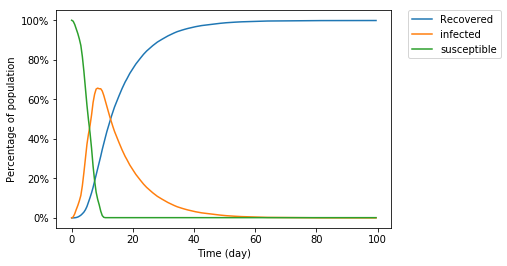

In [102]:
time = np.arange(0.0,100.0,0.5)
ax = plt.subplot(1,1,1)
ax.plot(time,np.vectorize(percentage_recovered)(sir,time),label="Recovered")
ax.plot(time,np.vectorize(percentage_infected)(sir,time), label="infected")
ax.plot(time,np.vectorize(percentage_susceptible)(sir,time), label="susceptible")
ax.set_xlabel('Time (day)')
ax.set_ylabel('Percentage of population')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
def pct(x,pos): return "{}%".format(int(x*100))
ax.yaxis.set_major_formatter(plt.FuncFormatter(pct))

In [103]:
def bisection(f, low, high, eps=0.001):
    mid = (low+high)/2.0
    if f(mid)==0 or (high-low)/2.0 < eps:
        return mid
    else:
        if f(mid)*f(low) > 0:
            return bisection(f,mid,high,eps)
        else:
            return bisection(f,low,mid,eps)

In [104]:
print("It takes %.2f"% (bisection((lambda t:percentage_infected(sir,t)-0.6),0,20)), "days to have 60% of the population infected.")
print("It takes %.2f"% (bisection((lambda t:percentage_recovered(sir,t)-0.6),0,40)), "days to have 60% of the population dead.")

It takes 7.16 days to have 60% of the population infected.
It takes 14.99 days to have 60% of the population dead.


---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [139]:
graph = load_graph_from_file()
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(graph, beta=10.0, gamma=0.1)

# Remove edges at random
edges_to_remove = 1000
randomSample = rand.sample(graph.edges(), edges_to_remove)
graph.remove_edges_from(randomSample)

# Launch epidemic
sir.launch_epidemic(source=rand.randint(0, nx.number_of_nodes(graph) - 1), max_time=100.0)

Epidemic stopped after 101.93 days | 101.93 days elapsed | 0.4% susceptible, 0.0% infected, 99.6% recovered


No, this strategy is not very effective since we remove edges between nodes that might not be infected instead of removing edges between nodes that will be infected with high probability.

In [140]:
print("Number of susceptible people after 30 days:", number_susceptible(sir,30))
print("Number of infected people after 30 days:", number_infected(sir,30))
print("Number of recovered/dead people after 30 days:", number_recovered(sir,30))

Number of susceptible people after 30 days: 103
Number of infected people after 30 days: 2460
Number of recovered/dead people after 30 days: 23918


In [141]:
# We remove 9000 additional random edges
edges_to_remove = 9000
randomSample = rand.sample(graph.edges(), edges_to_remove)
graph.remove_edges_from(randomSample)

# Launch epidemic
sir.launch_epidemic(source=rand.randint(0, nx.number_of_nodes(graph) - 1), max_time=100.0)

print("Number of susceptible people after 30 days:", number_susceptible(sir,30))
print("Number of infected people after 30 days:", number_infected(sir,30))
print("Number of recovered/dead people after 30 days:", number_recovered(sir,30))

Epidemic stopped after 100.25 days | 100.25 days elapsed | 24.4% susceptible, 0.0% infected, 75.6% recovered
Number of susceptible people after 30 days: 6461
Number of infected people after 30 days: 2643
Number of recovered/dead people after 30 days: 17377


When removing 10000 edges, there are about 10% (wild guess) more healthy people than after removing 1000 edges.

#### Exercise 2.11: Strategy 2

In [143]:
# Algorithm: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4372451/

# ISSUE : VERIFIY HOW WE REMOVE EDGES, WE MIGHT REMOVE 2500 MORE EVERY TIME WE RUN

# INITIALIZATION
graph = load_graph_from_file()

# Consider only giant component
giant_comp = max(nx.connected_component_subgraphs(graph), key=nx.number_of_nodes)
nb_edges = nx.number_of_edges(giant_comp)
nb_edges_to_delete = 2500

In [17]:
# Compute centrality of every edge
centrality = nx.edge_betweenness_centrality(giant_comp) # took me approx 40min to run

In [85]:
# Use test_centrality and test_giant_component as a test, so that we don't have to compute centrality and giant_comp again
test_centrality = centrality
test_giant_component = giant_com

19776


In [84]:
# Remove edges
deleted_edges = []
nb_edges_to_delete = 2500

for i in range(0, nb_edges_to_delete):
    # get index of edge with highest centrality
    deleted_edges.append(keywithmaxval(test_centrality))
    test_centrality.pop(max(test_centrality, key=test_centrality.get))
    
# delete edges with highest centrality
test_giant_component.remove_edges_from(deleted_edges)

19776


In [70]:
# Need to relable vertices, since we only have a subgraph of the network we have some node indices missing
nb_nodes_test = nx.number_of_nodes(test_giant_component)
ordered_mapping = {}
for i in range(0, nb_nodes_test):
    ordered_mapping[test_giant_component.nodes()[i]] = i 
giant_comp_fixed_indices = nx.relabel_nodes(test_giant_component, ordered_mapping)

In [77]:
# Build the continuous-time SIR epidemic
sir = epidemics_helper.SimulationSIR(giant_comp_fixed_indices, beta=10.0, gamma=0.1)

# Launch epidemic
sir.launch_epidemic(source=rand.randint(0, nb_nodes - 1), max_time=100.0)

Epidemic stopped after 84.91 days | 84.91 days elapsed | 86.7% susceptible, 0.0% infected, 13.3% recovered


In [42]:
# http://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
def findMaxValue(dic): 
    v=list(dic.values())
    k=list(dic.keys())
    return k[v.index(max(v))]

We get the result:
Epidemic stopped after 84.91 days | 84.91 days elapsed | 86.7% susceptible, 0.0% infected, 13.3% recovered
with the new graph.